### The dprime calculator liberary 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

#   Copyright (C) 2012-2017 Samuele Carcagno <sam.carcagno@gmail.com>
#   This file is part of pysdt

#    pysdt is free software: you can redistribute it and/or modify
#    it under the terms of the GNU General Public License as published by
#    the Free Software Foundation, either version 3 of the License, or
#    (at your option) any later version.

#    pysdt is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#    GNU General Public License for more details.

#    You should have received a copy of the GNU General Public License
#    along with pysdt.  If not, see <http://www.gnu.org/licenses/>.

"""
A module for computing signal detection theory measures.
Some of the functions in this module have been ported to
python from the 'psyphy' R package of Kenneth Knoblauch
http://cran.r-project.org/web/packages/psyphy/index.html
"""
from __future__ import nested_scopes, generators, division, absolute_import, with_statement, print_function, unicode_literals
from scipy.stats import norm
from scipy.integrate import quad
from scipy.special import erf, erfinv
from scipy import Inf
import numpy, scipy
from numpy import exp, log, log10, sign, sqrt
import numpy as np
#from numpy.lib.scimath import logn #log with arbitrary base


def compute_proportions(nCA, nTA, nIB, nTB, corr):
    """
    Compute proportions with optional corrections for extreme proportions.

    Parameters
    ----------
    nCA : float
        Number of correct 'A' trials
    nTA : int
        Number of total 'A' trials
    nIB : float
        Number of incorrect 'B' trials
    nTB : int
        Number of total 'B' trials
    corr : string
        The correction to apply, `none` for no correction, 'loglinear` for the
        log-linear correction, and `2N` for the '2N' correction.

    Returns
    -------
    HR : float
        Hit rate
    FA : float
        False alarm rate

    Examples
    --------
    >>> H,F = compute_proportions(8, 10, 2, 10, "loglinear")
    >>> H,F = compute_proportions(10, 10, 2, 10, "loglinear")
    >>> H,F = compute_proportions(10, 10, 2, 10, "2N")

    References
    ----------
   .. [1] Hautus, M. J. (1995). Corrections for extreme proportions and their biasing effects on estimated values of *d'*. *Behavior Research Methods, Instruments, & Computers, 27(I)*, 46–51. http://doi.org/10.3758/BF03203619
   .. [2] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.

    
    """
    if corr == "loglinear":
        HR = (nCA+0.5)/(nTA+1)
        FR = (nIB+0.5)/(nTB+1)
    elif corr == "2N":
        if nCA == nTA:
            HR = 1 - 1/(2*nTA)
        elif nCA == 0:
            HR = 1 / (2*nTA)
        else:
            HR = nCA/(nTA)

        if nIB == nTB:
            FR = 1 - 1/(2*nTB)
        elif nIB == 0:
            FR = 1 / (2*nTB)
        else:
            FR = nIB/(nTB)
    else:
        HR = nCA/nTA
        FR = nIB/nTB

    return HR, FR



def dprime_mAFC(Pc, m):
    """
    Compute *d'* corresponding to a certain proportion of correct
    responses in m-AFC tasks.

    Parameters
    ----------
    Pc : float
        Proportion of correct responses.
    m : int
        Number of alternatives.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_mAFC(0.7, 3)

    References
    ----------
   .. [1] Green, D. M., & Swets, J. A. (1988). *Signal Detection Theory and Psychophysics*. Los Altos, California: Peninsula Publishing.
   .. [2] Green, D. M., & Dai, H. P. (1991). Probability of being correct with 1 of M orthogonal signals. *Perception & Psychophysics, 49(1)*, 100–101.
    
    """

    if Pc < 0 or Pc > 1:
        raise ValueError("Pc must be between 0 and 1")
    if isinstance(m, int) == False:
        raise TypeError("m must be an int")
    
    def est_dp(dp):

        def pr(x):
            return (norm.pdf(x-dp) * (norm.cdf(x)**(m-1)))
        
        return (Pc - quad(pr, -Inf, Inf)[0])
    try:
        dprime = scipy.optimize.brentq(est_dp, -10, 10)#scipy.optimize.newton(est_dp, 1)
    except:
        dprime = numpy.nan
    
    return dprime




def dprime_ABX(H, FA, meth):
    """
    Compute *d'* for ABX task from 'hit' and 'false alarm' rates.

    Parameters
    ----------
    H : float
        Hit rate.
    FA : float
        False alarms rate.
    meth : string
        'diff' for differencing strategy or 'IO' for independent observations strategy.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_ABX(0.7, 0.2, 'IO')
    >>> dp = dprime_ABX(0.7, 0.2, 'diff')

    References
    ----------
    .. [1] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.

    """

    if H < 0 or H > 1:
        raise ValueError("H must be between 0 and 1")
    if FA < 0 or FA > 1:
        raise ValueError("FA must be between 0 and 1")

    zdiff = norm.ppf(H) - norm.ppf(FA)
    pcUnb = norm.cdf(zdiff/2)
    if pcUnb < 0.5:
        #raise ValueError("H must be greater than FA")
        dpsign = -1
        zdiff = norm.ppf(FA) - norm.ppf(H)
        pcUnb = norm.cdf(zdiff/2)
    else:
        dpsign = 1

        
    root2 = sqrt(2)
    if meth == "diff":
        root6 = sqrt(6)
        def est_dp2(dp):
            return pcUnb - norm.cdf(dp/root2) * norm.cdf(dp/root6) - norm.cdf(-dp/root2) * norm.cdf(-dp/root6)
        try:
            dprime =  scipy.optimize.brentq(est_dp2, 0, 10)
        except:
            dprime = numpy.nan
    elif meth == "IO":
        def est_dp2(dp):
            return pcUnb - norm.cdf(dp/root2) * norm.cdf(dp/2) - norm.cdf(-dp/root2) * norm.cdf(-dp/2)
        try:
            dprime =  scipy.optimize.brentq(est_dp2, 0, 10)
        except:
            dprime = numpy.nan
    # if H == FA:
    #     dprime = 0
    return dprime*dpsign


def dprime_ABX_from_counts(nCA, nTA, nCB, nTB, meth, corr):
    """
    Compute *d'* for ABX task from counts of correct and total responses.

    Parameters
    ----------
    nCA : int
        Number of correct responses in 'same' trials.
    nTA : int
        Total number of 'same' trials.
    nCB : int
        Number of correct responses in 'different' trials.
    nTB : int
        Total number of 'different' trials.
    meth : string
        'diff' for differencing strategy or 'IO' for independent observations strategy.
    corr : logical
         if True, apply the correction to avoid hit and false alarm rates of 0 or one.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_ABX(0.7, 0.2, 'IO')

    References
    ----------
    .. [1] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.

    """

    if nCA > nTA:
        raise ValueError("nCA must be <= than nTA")
    if nCB > nTB:
        raise ValueError("nCB must be <= than nTB")
    
    if corr == True:
        if nCA == nTA:
            tA = 1 - 1/(2*nTA)
        elif nCA == 0:
            tA = 1 / (2*nTA)
        else:
            tA = nCA/(nTA)

        if nCB == nTB:
            tB = 1 - 1/(2*nTB)
        elif nCB == 0:
            tB = 1 / (2*nTB)
        else:
            tB = nCB/(nTB)
    else:
        tA = nCA/nTA
        tB = nCB/nTB

    return dprime_ABX(H=tA, FA=1-tB, meth=meth)


def dprime_oddity(prCorr, meth="diff"):
    """
    Compute *d'* for oddity task from proportion of correct responses.
    Only valid for the case in which there are three presentation intervals.

    Parameters
    ----------
    prCorr : float
        Proportion of correct responses.
    meth : string
        'diff' for differencing strategy or 'IO' for independent observations strategy.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_oddity(0.7)
    >>> dp = dprime_oddity(0.8)

    References
    ----------
    .. [1] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.
    .. [2] Versfeld, N. J., Dai, H., & Green, D. M. (1996). The optimum decision rules for the oddity task. *Perception & Psychophysics, 58(1)*, 10–21.

    """
    
    if prCorr < 1/3:
        raise ValueError("Only valid for Pc.tri > 1/3")

    if meth == "diff":
        root3 = sqrt(3)
        root2_3 = sqrt(2)/root3
        def est_dp(dp):

            def pr(x):

                out =  2 *(norm.cdf(-x * root3 + dp * root2_3) + norm.cdf(-x * root3 - dp * root2_3)) * norm.pdf(x)

                return out

            out2 = prCorr - quad(pr, 0, Inf)[0] 

            return out2
        try:
            dp_res = scipy.optimize.brentq(est_dp, 0, 10)
        except:
            dp_res = numpy.nan
    elif meth == "IO":
        def est_dp(dp):
            def pr1(x):
                return norm.pdf(x)*norm.cdf(x+dp)**2
            def pr2(x):
                return norm.pdf(x)*(1-norm.cdf(x+dp))**2

            out = prCorr - (norm.cdf(dp/2)**3 + quad(pr1, -Inf, -dp/2)[0] + (1-norm.cdf(dp/2))**3 + quad(pr2, -dp/2, Inf)[0])

            return out

        try:
            dp_res = scipy.optimize.brentq(est_dp, 0, 10)
        except:
            dp_res = numpy.nan

    return dp_res

        



def dprime_SD(H, FA, meth):
    """
    Compute *d'* for one interval same/different task from 'hit' and 'false alarm' rates.

    Parameters
    ----------
    H : float
        Hit rate.
    FA : float
        False alarms rate.
    meth : string
        'diff' for differencing strategy or 'IO' for independent observations strategy.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_SD(0.7, 0.2, 'IO')

    References
    ----------
    .. [1] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.
    .. [2] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.

    """

    if H < 0 or H > 1:
        raise ValueError("H must be between 0 and 1")
    if FA < 0 or FA > 1:
        raise ValueError("FA must be between 0 and 1")
    
    if meth == "diff":
        k = sqrt(2) * norm.ppf(FA/2)
        def est_dp2(dp):
            return H - norm.cdf((k+dp)/sqrt(2)) - norm.cdf((k-dp)/sqrt(2))
        #dprime =  scipy.optimize.newton(est_dp2, 1)
        try:
            dprime =  scipy.optimize.brentq(est_dp2, 0, 10)
        except:
            if H == FA:
                dprime = 0
            else:
                dprime = numpy.nan
    elif meth == "IO":
        zdiff = norm.ppf(H) - norm.ppf(FA)
        pcMax = norm.cdf(zdiff/2)
        dp_sign = sign(pcMax - 0.5)
        if pcMax < 0.5:
            val = 2 * norm.ppf(0.5 * (1 + sqrt(2 * (1 - pcMax) - 1)))
        else:
            val = 2 * norm.ppf(0.5 * (1 + sqrt(2 * pcMax - 1)))
        dprime = dp_sign*val
    return dprime



def dprime_SD_from_counts(nCA, nTA, nCB, nTB, meth, corr):
    """
    Compute *d'* for one interval same/different task from counts of correct and total responses.

    Parameters
    ----------
    nCA : int
        Number of correct responses in 'same' trials.
    nTA : int
        Total number of 'same' trials.
    nCB : int
        Number of correct responses in 'different' trials.
    nTB : int
        Total number of 'different' trials.
    meth : string
        'diff' for differencing strategy or 'IO' for independent observations strategy.
    corr : logical
         if True, apply the correction to avoid hit and false alarm rates of 0 or one.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_SD(0.7, 0.2, 'IO')

    References
    ----------
    .. [1] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.
    .. [2] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.

    """

    if nCA > nTA:
        raise ValueError("nCA must be <= than nTA")
    if nCB > nTB:
        raise ValueError("nCB must be <= than nTB")
    
    if corr == True:
        if nCA == nTA:
            tA = 1 - 1/(2*nTA)
        elif nCA == 0:
            tA = 1 / (2*nTA)
        else:
            tA = nCA/(nTA)

        if nCB == nTB:
            tB = 1 - 1/(2*nTB)
        elif nCB == 0:
            tB = 1 / (2*nTB)
        else:
            tB = nCB/(nTB)
    else:
        tA = nCA/nTA
        tB = nCB/nTB

    return dprime_SD(H=tA, FA=1-tB, meth=meth)



def dprime_yes_no(H, FA):
    """
    Compute *d'* for one interval 'yes/no' type tasks from hits and false alarm rates.

    Parameters
    ----------
    H : float
        Hit rate.
    FA : float
        False alarms rate.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_yes_no(0.7, 0.2)

    References
    ----------
    .. [1] Green, D. M., & Swets, J. A. (1988). *Signal Detection Theory and Psychophysics*. Los Altos, California: Peninsula Publishing.
    .. [2] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.

    """
    
    if H < 0 or H > 1:
        raise ValueError("H must be between 0 and 1")
    if FA < 0 or FA > 1:
        raise ValueError("FA must be between 0 and 1")

    return norm.ppf(H) - norm.ppf(FA)



def dprime_yes_no_from_counts(nCA, nTA, nCB, nTB, corr):
    """
    Compute *d'* for one interval 'yes/no' type tasks from counts of correct and total responses.

    Parameters
    ----------
    nCA : int
        Number of correct responses in 'signal' trials.
    nTA : int
        Total number of 'signal' trials.
    nCB : int
        Number of correct responses in 'noise' trials.
    nTB : int
        Total number of 'noise' trials.
    corr : logical
         if True, apply the correction to avoid hit and false alarm rates of 0 or one.

    Returns
    -------
    dprime : float
        *d'* value

    Examples
    --------
    >>> dp = dprime_yes_no_from_counts(nCA=70, nTA=100, nCB=80, nTB=100, corr=True)

    References
    ----------
    .. [1] Green, D. M., & Swets, J. A. (1988). *Signal Detection Theory and Psychophysics*. Los Altos, California: Peninsula Publishing.
    .. [2] Macmillan, N. A., & Creelman, C. D. (2004). *Detection Theory: A User’s Guide (2nd ed.)*. London: Lawrence Erlbraum Associates.

    """
    
    if nCA > nTA:
        raise ValueError("nCA must be <= than nTA")
    if nCB > nTB:
        raise ValueError("nCB must be <= than nTB")

    if corr == True:
        if nCA == nTA:
            tA = 1 - 1/(2*nTA)
        elif nCA == 0:
            tA = 1 / (2*nTA)
        else:
            tA = nCA/(nTA)

        if nCB == nTB:
            tB = 1 - 1/(2*nTB)
        elif nCB == 0:
            tB = 1 / (2*nTB)
        else:
            tB = nCB/(nTB)
    else:
        tA = nCA/nTA
        tB = nCB/nTB

    return norm.ppf(tA) - norm.ppf(1-tB)


def logisticPsy(x, alphax, betax, gammax, lambdax):
    """
    Compute the logistic psychometric function.

    Parameters
    ----------
    x : 
        Stimulus level(s).
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function (guess rate).
    lambdax:
        The lapse rate.

    Returns
    -------
    pc :
         Proportion correct at the stimulus level(s) `x`.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.

    """
    
    out = gammax + (1-gammax-lambdax) *(1/(1+exp(betax*(alphax-x))))
    return out


def invLogisticPsy(p, alphax, betax, gammax, lambdax):
    """
    Compute the inverse logistic psychometric function.

    Parameters
    ----------
    p : 
        Proportion correct on the psychometric function.
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function.
    lambdax:
        The lapse rate.

    Returns
    -------
    x :
         Stimulus level at which proportion correct equals `p`
         for the listener specified by the function.
    
    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """

    x = alphax - (1/betax)*log((1-gammax-lambdax)/(p-gammax) - 1)
    return x


def logisticLikelihood(lev, response, alphax, betax, gammax, lambdax):

    p = logistic(lev, alphax, betax, gammax, lambdax)
    if response == 1:
        ll = log(p)
    elif response == 0:
        ll = log(1-p)
    

    return ll


def gaussianPsy(x, alphax, betax, gammax, lambdax):
    """
    Compute the gaussian psychometric function.

    Parameters
    ----------
    x : 
        Stimulus level(s).
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function (guess rate).
    lambdax:
        The lapse rate.

    Returns
    -------
    pc :
         Proportion correct at the stimulus level(s) `x`.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    # as in UML toolbox
    out = gammax+(1-gammax-lambdax)*(1+erf((x-alphax)/sqrt(2*betax**2)))/2
    return out


def invGaussianPsy(p, alphax, betax, gammax, lambdax):
    """
    Compute the inverse gaussian psychometric function.

    Parameters
    ----------
    p : 
        Proportion correct on the psychometric function.
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function.
    lambdax:
        The lapse rate.

    Returns
    -------
    x :
         Stimulus level at which proportion correct equals `p`
         for the listener specified by the function.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    out = alphax + sqrt(2*betax**2)*erfinv(2*(p-gammax)/(1-gammax-lambdax)-1)
    return out


def weibullPsy(x, alphax, betax, gammax, lambdax):
    """
    Compute the weibull psychometric function.

    Parameters
    ----------
    x : 
        Stimulus level(s).
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function (guess rate).
    lambdax:
        The lapse rate.

    Returns
    -------
    pc :
         Proportion correct at the stimulus level(s) `x`.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    out = gammax+(1-gammax-lambdax)*(1-numpy.exp(-(x/alphax)**betax))
    return out


def invWeibullPsy(p, alphax, betax, gammax, lambdax):
    """
    Compute the inverse weibull psychometric function.

    Parameters
    ----------
    p : 
        Proportion correct on the psychometric function.
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function.
    lambdax:
        The lapse rate.

    Returns
    -------
    x :
         Stimulus level at which proportion correct equals `p`
         for the listener specified by the function.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    out = alphax * (np.power(-log(1-(p-gammax)/(1-gammax-lambdax)), 1/betax))
    return out

    
def gumbelPsy(x, alphax, betax, gammax, lambdax):
    """
    Compute the gumbel psychometric function.

    Parameters
    ----------
    x : 
        Stimulus level(s).
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function (guess rate).
    lambdax:
        The lapse rate.

    Returns
    -------
    pc :
         Proportion correct at the stimulus level(s) `x`.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    out = gammax + (1-gammax-lambdax) * (1-numpy.exp(-10**(betax*(x-alphax))))
    return out


def invGumbelPsy(p, alphax, betax, gammax, lambdax):
    """
    Compute the inverse gumbel psychometric function.

    Parameters
    ----------
    p : 
        Proportion correct on the psychometric function.
    alphax:
        Mid-point(s) of the psychometric function.
    betax:
        The slope of the psychometric function.
    gammax:
        Lower limit of the psychometric function.
    lambdax:
        The lapse rate.

    Returns
    -------
    x :
         Stimulus level at which proportion correct equals `p`
         for the listener specified by the function.

    References
    ----------- 
    .. [1] Kingdom, F. A. A., & Prins, N. (2010). *Psychophysics: A Practical Introduction*. Academic Press.
    
    """
    out = alphax + (log10(-log(1 - (p-gammax)/(1-gammax-lambdax))))/betax
    return out



### This code count the numer of correctness with given result four csv files.  

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

#Input: result 4 csv directories with 'dew6' or 'sg16'  or 'yckr'  or 'venc'
#Output: a list of csv directory 
def find_resultCSV(dir):
    csv_files = glob.glob(dir +"/*.csv")
    result_files = [i.replace('\\', '/') for i in csv_files]
    result_files = [file for file in result_files if 'dew6'in file or 'sg16' in file or 'ubyv' in file or 'kee1' in file]

    return result_files

#Input: a direcotry with the result csv file
#Output: a dataframe with different types of trials and number of correct response for every type
def count(dir):
    result_files = find_resultCSV(dir)
    #print(result_files)

    #Extract the 'Absent_Present' & 'Length' & 'Attend_Condition' & 'Response' from every csv file
    df = pd.concat([pd.read_csv(file, usecols=['Participant Private ID','Absent_Present', 'Non_attend_dim', 'Attend_Condition', 'Response']) for file in result_files])
    df = df.query('Response != "AUDIO PLAY REQUESTED"').dropna(subset=['Response'])
    #print(df)
    
    #Count total number of trials in each task
    countTask = df.groupby(['Participant Private ID','Absent_Present','Non_attend_dim','Attend_Condition']).size().reset_index(name='Counts')
    #print(countTask)

    #Count the number of correct trials in each task
    df['is_correct'] = df.apply(lambda x: 1 if x['Response'] == x['Absent_Present'] else 0, axis=1)
    df_grouped2 = df.groupby(['Participant Private ID','Absent_Present','Non_attend_dim','Attend_Condition','is_correct']).size().reset_index(name='num_correct')
    df_grouped2 = df_grouped2.query('is_correct != 0')
    df_grouped2 = df_grouped2.drop(columns=['is_correct']).reset_index(drop=True)
    #print(df_grouped2)

    #Add a percent_correct column 
    df_appended = pd.concat([df_grouped2, countTask.iloc[:,-1]], axis=1)
    df_appended = df_appended.eval("percent_correct = num_correct/Counts")
    #print(df_appended)

    return df_appended


#Input: a dataframe with different types of trials and number of correct response for every type
#Output: dprime values for each task (6 dimension)
def cal_dprime (df):
    #print(df)
    #Initialize 4 zero-lists with length six 
    #6 dimensions:  len4 pitch/word--len5 pitch/word--len6 pitch/word
    num_presentC, num_present, num_absentC, num_absent = [[0]*6 for _ in range(4)]
    

    # six case 4 pitch/word; 5 pitch/word; 6 pitch/word 
    num_presentC = df['num_correct'].iloc[len(df)//2:].values.tolist()
    num_present = df['Counts'].iloc[len(df)//2:].values.tolist()
    num_absentC = df['num_correct'].iloc[:len(df)//2].values.tolist()
    num_absent = df['Counts'].iloc[:len(df)//2].values.tolist()
    #print('present: ',num_presentC)
    #print(num_present) 
    #print('absent: ',num_absentC)
    #print(num_absent)

    #calculate dprime
    # fixed pitch, fixed word, random pitch, random word
    dprime = np.zeros(4)
    for i in range(4):
        #dprime[i] = dprime_SD_from_counts(num_presentC[i], num_present[i], num_absentC[i], num_absent[i], meth='diff', corr=True)
        dprime[i] = dprime_yes_no_from_counts(num_presentC[i], num_present[i], num_absentC[i], num_absent[i], corr=True)
    dprime = np.nan_to_num(dprime, 0.0)
    #print(dprime)

    return dprime

def plot_dprime(dprime,i):
    x = [4, 6, 8]
    pitch = [dprime[0], dprime[2], dprime[4]]
    word = [dprime[1], dprime[3], dprime[5]]
    plt.figure()
    plt.plot(x, pitch, 'r-o', label = 'pitch')
    plt.plot(x , word, 'g-o', label = 'word')
    plt.title(f'subject {i}: d\' of task-P/A ')
    plt.xlabel('sequence length', fontsize = 15)
    plt.ylabel('d\' value', fontsize = 15)
    plt.xticks(x)
    plt.ylim([-5, 5])
    plt.legend()

def plot_precentageCorrectness(df):
    x = [4, 6, 8]

    percent_correct = df['percent_correct'].values.tolist()
    #print(percent_correct)

    #abscent pitch/qord
    ap = [percent_correct[0], percent_correct[2], percent_correct[4]] #[20/38, 15/30, 21/41]
    aw = [percent_correct[1], percent_correct[3], percent_correct[5]] #[20/25, 18/35, 28/37]
    #present pitch/word
    pp = [percent_correct[6], percent_correct[8], percent_correct[10]] #[6/10, 15/30, 16/31]
    pw = [percent_correct[7], percent_correct[9], percent_correct[11]] #[19/23, 13/25, 27/35]

    plt.plot(x , pw, 'r-*', label = 'present-word')
    plt.plot(x, pp, 'b-*', label = 'present-pitch')
    plt.plot(x , aw, 'm-.o', label = 'absent-word')
    plt.plot(x, ap, 'g-.o', label = 'absent-pitch')

    plt.xlabel('sequence length', fontsize = 15)
    plt.ylabel('correctness', fontsize = 15)
    plt.title('P/A Task single subject')
    plt.legend()
    plt.show()

def plot_dprime_individual(dprime,i):
    x = ['fixed', 'randomized']
    pitch = [dprime[0], dprime[2]]
    word = [dprime[1], dprime[3]]
    plt.figure()
    plt.plot(x, pitch, 'ro-', label = 'pitch')
    plt.plot(x , word, 'go-', label = 'syllable')
    plt.title(f'subjects {i}: d\' of task-P/A ')
    plt.xlabel('non-attended dimension', fontsize = 15)
    plt.ylabel('d\' value', fontsize = 15)
    plt.xticks(x)
    plt.ylim([-5, 5])
    plt.legend()   


def plot_dprime_all(dprime,i):
    x = ['fixed', 'randomized']
    pitch = [dprime[0], dprime[2]]
    word = [dprime[1], dprime[3]]
    plt.plot(x, pitch, 'r--o', alpha = 0.09)#, label = 'pitch')
    plt.plot(x , word, 'g--o', alpha = 0.09)#, label = 'syllable')
    plt.title(f'total subjects {i}: d\' of task-P/A ')
    plt.xlabel('non-attended dimension', fontsize = 15)
    plt.ylabel('d\' value', fontsize = 15)
    plt.xticks(x)
    plt.ylim([-2, 3])
    plt.legend(['pitch','syllable'])

### Result Plots

    Participant Private ID Absent_Present Non_attend_dim Attend_Condition  \
0                8554460.0         absent          fixed        ### pitch   
1                8554460.0         absent          fixed         ### word   
2                8554460.0         absent           rand        ### pitch   
3                8554460.0         absent           rand         ### word   
4                8554460.0        present          fixed        ### pitch   
5                8554460.0        present          fixed         ### word   
6                8554460.0        present           rand        ### pitch   
7                8554460.0        present           rand         ### word   
8                8587316.0         absent          fixed        ### pitch   
9                8587316.0         absent          fixed         ### word   
10               8587316.0         absent           rand        ### pitch   
11               8587316.0         absent           rand         ### word   

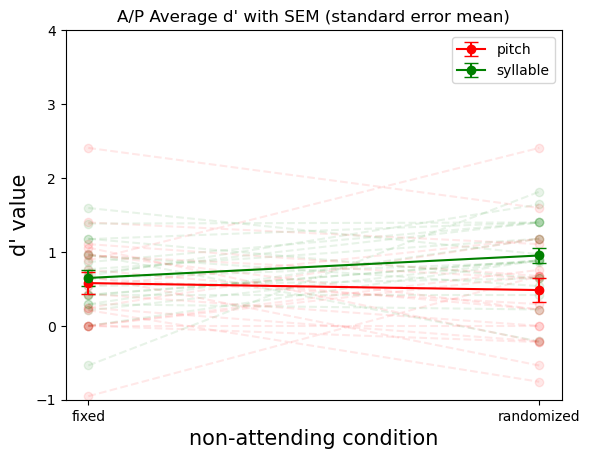

In [51]:
#dir1 = "E:/cmu/lab project/result & analysis/AP_result/yutian-syllable"
# dir1 = "E:/cmu/lab project/result & analysis/AP_result/yuhang-syllable"
# dir2 = "E:/cmu/lab project/result & analysis/AP_result/eli-syllable"
# dir = [dir1,dir2]

dir = ["E:/cmu/lab project/New folder/New folder/AP"]
dir1 = "E:/cmu/lab project/New folder/data_3_pilots/data_exp_127771-v4"
dir2 = "E:/cmu/lab project/New folder/data-4-27"
dir = [dir1, dir2]

dprime_sum = np.zeros(4)
dprime_list = []

for i in range(len(dir)):
    # use same axis
    df = count(dir[i])
    
    # group data frame by 'Participant Private ID' column
    grouped = df.groupby('Participant Private ID')
    # create a list of data frames
    list_of_dfs = [group for _, group in grouped]

    # print list of data frames
    for j, df in enumerate(list_of_dfs):
        #print(df)
        dprime = cal_dprime(df)
        #plot_dprime_individual(dprime, j+1)
        plot_dprime_all(dprime, j + 1 + 3)

        dprime_sum += dprime
        dprime_list.append(dprime)

# # x = [4, 6, 8]
x = ['fixed', 'randomized']
# Plot the average d' with error bars
dprime_array = np.array(dprime_list)
dprime_avg = np.mean(dprime_array, axis=0)
dprime_sem = np.std(dprime_array, axis=0) / np.sqrt(len(dprime_list))
#plt.figure()
plt.errorbar(x, dprime_avg[0::2], yerr=dprime_sem[0::2], fmt='ro-', label='pitch', capsize=5)
plt.errorbar(x, dprime_avg[1::2], yerr=dprime_sem[1::2], fmt='go-', label='syllable', capsize=5)
plt.title('A/P Average d\' with SEM (standard error mean)')
plt.xlabel('non-attending condition', fontsize = 15)
plt.ylabel('d\' value')
plt.xticks(x)
plt.ylim([-1, 4])
plt.legend()
plt.show()

###
#A negative d' (d-prime) value in the context of signal detection theory typically suggests that the participant's responses were systematically opposite to what was expected. 


In [16]:
print(len(dprime_list))
print(len(dprime_list[0]))

# Create a DataFrame
df = pd.DataFrame(dprime_list, columns=['Fixed Pitch', 'Fixed Syllable', 'Randomized Pitch', 'Randomized Syllable'])
print(df)
# Save the DataFrame to a CSV file
df.to_csv('P_A_dprime_result.csv', index=False)

20
4
     Fixed Pitch  Fixed Syllable  Randomized Pitch  Randomized Syllable
0  -9.522668e-01        0.764243          0.674490             1.177850
1   0.000000e+00        0.420857         -0.220299             0.884918
2   0.000000e+00        0.674490          0.756993             1.641911
3   2.104284e-01        0.641156         -0.756993             0.861455
4   9.522668e-01       -0.536694          0.641156             1.813721
5   6.411557e-01        0.952267          0.292932             0.536694
6   1.398149e+00        1.382994          1.105217             1.398149
7   2.406154e+00        0.861455          1.593423             1.398149
8   7.569932e-01        1.172566          0.220299             1.398149
9   8.849181e-01        0.420857          2.406154             0.420857
10  4.307273e-01        0.967422          0.000000            -0.210428
11  1.105217e+00        0.415573          0.674490             0.884918
12 -2.775558e-16        0.536694          0.674490         

#### Compare the attend_condition

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_PA = pd.read_csv('P_A_dprime_result.csv')
df_SD = pd.read_csv('S_D_dprime_result.csv')

df_PA['Experiment'] = 'P_A'
df_SD['Experiment'] = 'S_D'

df = pd.concat([df_PA, df_SD])
#print(df)

In [36]:
df_PA = df[df['Experiment'] == 'P_A']
df_SD = df[df['Experiment'] == 'S_D']

fixed_list = [[row_PA['Fixed Pitch'], row_PA['Fixed Syllable'], row_SD['Fixed Pitch'], row_SD['Fixed Syllable']] 
              for (_, row_PA), (_, row_SD) in zip(df_PA.iterrows(), df_SD.iterrows())]
print(len(fixed_list))
print(len(fixed_list[0]))

randomized_list = [[row_PA['Randomized Pitch'], row_PA['Randomized Syllable'], row_SD['Randomized Pitch'], row_SD['Randomized Syllable']] 
                   for (_, row_PA), (_, row_SD) in zip(df_PA.iterrows(), df_SD.iterrows())]
print(len(randomized_list))
print(len(randomized_list[0]))

20
4
20
4


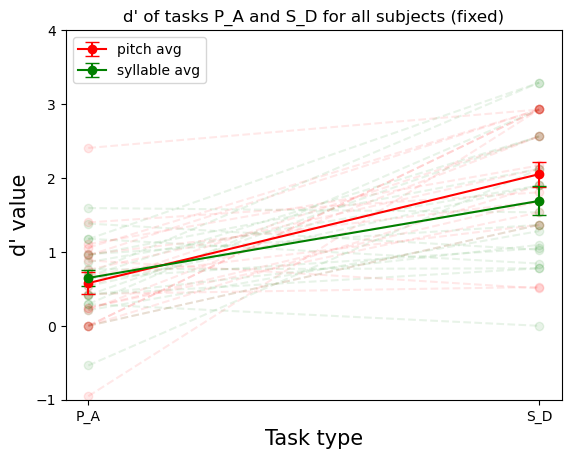

In [47]:
# Convert fixed_list to numpy array for easier calculations
dprime_array = np.array(fixed_list)

# Calculate average and standard error
dprime_avg = np.mean(dprime_array, axis=0)
dprime_sem = np.std(dprime_array, axis=0) / np.sqrt(len(fixed_list))

# Plotting
x = ['P_A', 'S_D']

# Plot data for all subjects
for i, dprime in enumerate(fixed_list):
    pitch = [dprime[0], dprime[2]]
    syllable = [dprime[1], dprime[3]]
    plt.plot(x, pitch, 'r--o', alpha=0.09)
    plt.plot(x , syllable, 'g--o', alpha=0.09)

# Plot average d' with error bars
plt.errorbar(x, dprime_avg[0::2], yerr=dprime_sem[0::2], fmt='ro-', label='pitch avg', capsize=5)
plt.errorbar(x, dprime_avg[1::2], yerr=dprime_sem[1::2], fmt='go-', label='syllable avg', capsize=5)

plt.title('d\' of tasks P_A and S_D for all subjects (fixed)')
plt.xlabel('Task type', fontsize=15)
plt.ylabel('d\' value', fontsize=15)
plt.xticks(x)
plt.ylim([-1, 4])
plt.legend()
plt.show()

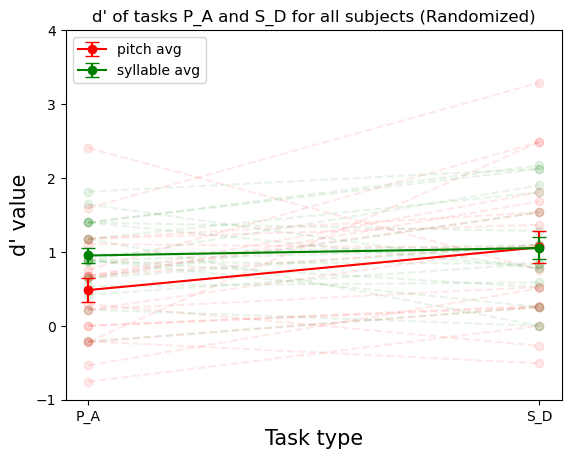

In [46]:
# Convert randomized_list to numpy array for easier calculations
dprime_array_random = np.array(randomized_list)

# Calculate average and standard error
dprime_avg_random = np.mean(dprime_array_random, axis=0)
dprime_sem_random = np.std(dprime_array_random, axis=0) / np.sqrt(len(randomized_list))

# Plotting
x = ['P_A', 'S_D']

# Plot data for all subjects
for i, dprime in enumerate(randomized_list):
    pitch = [dprime[0], dprime[2]]
    syllable = [dprime[1], dprime[3]]
    plt.plot(x, pitch, 'r--o', alpha=0.09)
    plt.plot(x , syllable, 'g--o', alpha=0.09)

# Plot average d' with error bars
plt.errorbar(x, dprime_avg_random[0::2], yerr=dprime_sem_random[0::2], fmt='ro-', label='pitch avg', capsize=5)
plt.errorbar(x, dprime_avg_random[1::2], yerr=dprime_sem_random[1::2], fmt='go-', label='syllable avg', capsize=5)

plt.title('d\' of tasks P_A and S_D for all subjects (Randomized)')
plt.xlabel('Task type', fontsize=15)
plt.ylabel('d\' value', fontsize=15)
plt.xticks(x)
plt.ylim([-1, 4])
plt.legend()
plt.show()


### Statistical -test

#### Library & function

In [4]:
import numpy as np
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

In [5]:
def process_list(lst, remove_zeros=False):
    lst = np.array(lst)
    lst1 = np.split(lst, lst.shape[1], axis=1)
    # Unpack the list into four arrays
    fix_P, fix_S, rand_P, rand_S = lst1

    # Optionally remove zero elements from the arrays
    if remove_zeros:
        fix_P = fix_P[fix_P != 0]
        fix_S = fix_S[fix_S != 0]
        rand_P = rand_P[rand_P != 0]
        rand_S = rand_S[rand_S != 0]
        # fix_P = fix_P[fix_P > 1]
        # fix_S = fix_S[fix_S > 1]
        # rand_P = rand_P[rand_P > 1]
        # rand_S = rand_S[rand_S > 1]

    # Return the resulting arrays
    return fix_P, fix_S, rand_P, rand_S

def two_sample_ttest(group1, group2, alpha=0.05):
    # Calculate the t-test statistic and p-value
    t_statistic, p_value = ttest_ind(group1, group2)

    # Determine significance level
    if p_value < alpha:
        result = "The difference in means is statistically significant at the {}% confidence level.".format((1-alpha)*100)
    else:
        result = "The difference in means is not statistically significant at the {}% confidence level.".format((1-alpha)*100)

    # print("t-statistic:", t_statistic)
    # print("p-value:", p_value)
    print(result)

    # Return the results
    return t_statistic, p_value, result


#### Data Preprocessing

In [6]:
fix_P, fix_S, rand_P, rand_S = process_list(dprime_list, remove_zeros=False)
# print(dprime_list)
# print("fix_P:", fix_P.mean())
# print("fix_S:", fix_S.mean())
# print("rand_P:", rand_P.mean())
# print("rand_S:", rand_S.mean())

fix_P = fix_P.flatten()
fix_S = fix_S.flatten()
rand_P = rand_P.flatten()
rand_S = rand_S.flatten()

# print(fix_P.mean())
# print(fix_S.mean())
# print(rand_P.mean())
# print(rand_S.mean())

# Combine the arrays into a single DataFrame
n_subjects = 20

df = pd.DataFrame({
    'subject': np.tile(np.arange(1, n_subjects+1), 4),  # Create 'subject' column
    'task': np.repeat(['P/A','P/A','P/A','P/A'], [len(fix_P), len(fix_S), len(rand_P), len(rand_S)]),
    'attend_condition': np.repeat(['pitch', 'syllable', 'pitch', 'syllable'], [len(fix_P), len(fix_S), len(rand_P), len(rand_S)]),
    'structure': np.repeat(['fixed', 'fixed', 'random', 'random'], [len(fix_P), len(fix_S), len(rand_P), len(rand_S)]),
    'dprime': np.concatenate([fix_P, fix_S, rand_P, rand_S])
})

df.to_csv('PA_dprime.csv', index=False)

mean_dprime = df.groupby(['task','attend_condition', 'structure'])['dprime'].mean()
print(mean_dprime)

#save df in a csv file 
mean_dprime_reset = mean_dprime.reset_index() #kept the same column
mean_dprime_reset.to_csv('PA_mean_dprime.csv', index=False)

task  attend_condition  structure
P/A   pitch             fixed        0.577852
                        random       0.483546
      syllable          fixed        0.647497
                        random       0.951110
Name: dprime, dtype: float64


#### factorial-Anova test

In [64]:
df1 = pd.read_csv('PA_dprime.csv')
df2 = pd.read_csv('SD_dprime.csv')
df3 = pd.concat([df1, df2])
#print(df3)
# assuming df is your DataFrame
fixed_df = df3[df3['structure'].str.contains('fixed')]
random_df = df3[df3['structure'].str.contains('random')]
print(fixed_df)
print(random_df)
# #perform three-way ANOVA
# model = ols("""dprime ~ C(task) +  C(structure) + C(attend_condition) +
#                C(task):C(structure) +  C(task):C(attend_condition)+ C(attend_condition):C(structure) + 
#                C(structure):C(task):C(attend_condition)""", data=df3).fit()

# # sm.stats.anova_lm(model, typ=2)

# # Perform the ANOVA
# anova_table = sm.stats.anova_lm(model, typ=2)

# # Round the values in the table to 2 decimal places
# anova_table_rounded = anova_table.round(3)

# print(anova_table_rounded)

    subject task attend_condition structure        dprime
0         1  P/A            pitch     fixed -9.522668e-01
1         2  P/A            pitch     fixed  0.000000e+00
2         3  P/A            pitch     fixed  0.000000e+00
3         4  P/A            pitch     fixed  2.104284e-01
4         5  P/A            pitch     fixed  9.522668e-01
..      ...  ...              ...       ...           ...
35       16  S/D         syllable     fixed  8.416212e-01
36       17  S/D         syllable     fixed  2.926405e+00
37       18  S/D         syllable     fixed  3.289707e+00
38       19  S/D         syllable     fixed  1.534899e+00
39       20  S/D         syllable     fixed -2.220446e-16

[80 rows x 5 columns]
    subject task attend_condition structure    dprime
40        1  P/A            pitch    random  0.674490
41        2  P/A            pitch    random -0.220299
42        3  P/A            pitch    random  0.756993
43        4  P/A            pitch    random -0.756993
44        5

In [8]:
from statsmodels.stats.power import FTestAnovaPower

# Parameters from your ANOVA output
F = 3.712
df_num = 1  # numerator degrees of freedom, equivalent to df_effect
df_denom = 152  # denominator degrees of freedom, equivalent to df_error

# Calculate effect size (Cohen's f)
f_squared = F / df_denom  # F = f_squared * df_denom
f = f_squared**0.5

# Define other parameters
alpha = 0.05  # Significance level
power = 0.80  # Desired power

# Initialize power analysis object
analysis = FTestAnovaPower()

# Calculate required sample size
sample_size = analysis.solve_power(effect_size=f, nobs=None, alpha=alpha, power=power, k_groups=2)
print(f'Required sample size: {sample_size}')

Required sample size: 323.32928314641623


##### 2 * 2 within subject ANOVA

In [66]:
import pingouin as pg

# Run the repeated measures ANOVA
aov = pg.rm_anova(dv='dprime', within=['task', 'attend_condition'], subject='subject', data=df3)

# Print the ANOVA table
print(aov)

# Run the repeated measures ANOVA
aov1 = pg.rm_anova(dv='dprime', within=['task', 'attend_condition'], subject='subject', data=fixed_df)

# Print the ANOVA table
print(aov1)

# Run the repeated measures ANOVA
aov2 = pg.rm_anova(dv='dprime', within=['task', 'attend_condition'], subject='subject', data=random_df)

# Print the ANOVA table
print(aov2)

###176 trials per person in total 96 - pa 12*8; 80 - sd 10*8

                    Source         SS  ddof1  ddof2         MS          F  \
0                     task  12.747617      1     19  12.747617  39.940932   
1         attend_condition   0.034569      1     19   0.034569   0.178663   
2  task * attend_condition   1.030854      1     19   1.030854   4.249065   

      p-unc  p-GG-corr       ng2  eps  
0  0.000005   0.000005  0.295036  1.0  
1  0.677270   0.677270  0.001134  1.0  
2  0.053225   0.053225  0.032736  1.0  
                    Source         SS  ddof1  ddof2         MS          F  \
0                     task  31.644166      1     19  31.644166  51.064928   
1         attend_condition   0.426864      1     19   0.426864   1.390562   
2  task * attend_condition   0.930858      1     19   0.930858   2.051857   

          p-unc     p-GG-corr       ng2  eps  
0  8.590801e-07  8.590801e-07  0.437249  1.0  
1  2.528664e-01  2.528664e-01  0.010372  1.0  
2  1.682687e-01  1.682687e-01  0.022345  1.0  
                    Source        

In [59]:
import numpy as np
from statsmodels.stats.power import FTestAnovaPower

# # Values from your ANOVA table
# F = 4.249065
# df_effect = 1
# df_error = 19

# #Calculate Cohen's f from F and degrees of freedom
# f = np.sqrt(F * df_effect / df_error)
# print(f)
ng2 = 0.032736
f = np.sqrt(ng2/(1-ng2))
print(f)

# Desired power and alpha level
power = 0.8
alpha = 0.05

# Initialize the power analysis object
power_analysis = FTestAnovaPower()

# Calculate the required sample size
# Note: this gives the total number of observations, not the number of subjects
n_total = power_analysis.solve_power(effect_size=f, nobs=4, alpha=alpha, power=power)

# Since each subject contributes 4 observations (one for each combination of task and attend_condition)
n_subjects = n_total

print(n_subjects)


0.18396715571313915


ValueError: need exactly one keyword that is None

In [ ]:
# Install the necessary packages if not already installed
if (!require(simr)) install.packages('simr')
if (!require(lme4)) install.packages('lme4')

# Load the necessary packages
library(simr)
library(lme4)

# Set the parameters
f <- 0.1839  # Cohen's f effect size
alpha <- 0.05  # significance level
power <- 0.8  # desired power
n_groups <- 4  # number of groups

# Convert Cohen's f to variance explained
r2 <- f^2 / (f^2 + 1)

# Define the null model
model <- lmer(response ~ 1 + (1|subject), 
              data = data.frame(response = rnorm(20*n_groups), subject = rep(1:20, each=n_groups)))

# Add the fixed effect size
fixef(model)["(Intercept)"] <- sqrt(r2 / (1 - r2))

# Define a function to do power analysis for a given sample size
power_analysis <- function(n) {
  # update the model with the new sample size
  model <- lmer(response ~ 1 + (1|subject), 
                data = data.frame(response = rnorm(n*n_groups), subject = rep(1:n, each=n_groups)))
  fixef(model)["(Intercept)"] <- sqrt(r2 / (1 - r2))
  
  # run the power analysis
  power <- powerSim(model, test=fixed("factor1", "lr"), nsim=1000)$power
  
  return(power)
}

# Start with a guessed sample size
n <- 20

# Conduct power analysis for different sample sizes until power >= desired power
while (power_analysis(n) < power) {
  n <- n + 1
}

# Print the minimum sample size required to achieve the desired power
print(n)


#### t-test


In [11]:
# Perform the t-test and determine significance level
print('Between fixed Pitch and Syllable')
t_statistic, p_value, result = two_sample_ttest(fix_P, fix_S, alpha=0.05)
# print("t-statistic:", t_statistic)
# print("p-value:", p_value)
# print(result)

# Perform the t-test and determine significance level
print('Between randomized Pitch and Syllable')
t_statistic, p_value, result = two_sample_ttest(rand_P, rand_S, alpha=0.05)
# print("t-statistic:", t_statistic)
# print("p-value:", p_value)
# print(result)

# Perform the t-test and determine significance level
print('Between fixed Pitch and randomized Pitch')
t_statistic, p_value, result = two_sample_ttest(fix_P, rand_P, alpha=0.05)
# print("t-statistic:", t_statistic)
# print("p-value:", p_value)
# print(result)

# Perform the t-test and determine significance level
print('Between fixed syllable and randomized syllable')
t_statistic, p_value, result = two_sample_ttest(rand_S, fix_S, alpha=0.05)
# print("t-statistic:", t_statistic)
# print("p-value:", p_value)
# print(result)


Between fixed Pitch and Syllable
The difference in means is not statistically significant at the 95.0% confidence level.
Between randomized Pitch and Syllable
The difference in means is statistically significant at the 95.0% confidence level.
Between fixed Pitch and randomized Pitch
The difference in means is not statistically significant at the 95.0% confidence level.
Between fixed syllable and randomized syllable
The difference in means is not statistically significant at the 95.0% confidence level.
